In [1]:
import torch
import torch.nn.functional as F
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
import oidn.wrapper
import importlib
importlib.reload(oidn.wrapper)
oidn_model = oidn.wrapper.load_model()


def plot_frame(frame):
    if frame.shape[0] == 1:
        frame = np.repeat(frame, 3, 0)
    frame = np.clip(frame, 0.0, 1.0)
    frame = np.einsum('kij->ijk', np.flip(frame, axis=1))
    plt.figure()
    plt.imshow(frame)
    plt.show()


def matrix_transform(mat, p):
    x = np.einsum('ij,jxy->ixy', mat[:3,:3], p)
    x += mat[:3, 3, np.newaxis, np.newaxis]
    x /= np.fmax(np.einsum('i,ixy->xy', mat[3,:3], p) + mat[3][3], 1e-6)
    return x

def process_position(position, mat):
    x = matrix_transform(mat, position)
    x = x[2:]
    x = np.clip(x, -1.0, 1.0)
    x = (x-np.mean(x)) / np.var(x)**0.5
    return x

def process_normal(normal, mat):
    # return np.einsum('ij,jxy->ixy', mat[:3,:3], normal)
    ro_s = np.array([*np.meshgrid(
        (np.arange(normal.shape[1])+0.0)/normal.shape[1],
        (np.arange(normal.shape[2])+0.0)/normal.shape[2]
    ), np.zeros(normal[0].shape)]).astype(np.float32)
    imat = np.linalg.inv(mat)
    ro = matrix_transform(imat, ro_s)
    def transform_rd(w):
        w = np.array(w)[:,np.newaxis,np.newaxis]
        r = matrix_transform(imat, ro_s+w)-ro
        r /= np.linalg.norm(r, axis=0)[np.newaxis, :, :]
        return r
    rd = transform_rd([0, 0, 1])
    ru = transform_rd([1, 0, 0])
    rv = transform_rd([0, 1, 0])
    n = np.einsum('ijxy,jxy->ixy', [ru, rv, rd], normal)
    return n


def load_data_file(filename, verbose=False):
    data = np.fromfile('data/'+filename, dtype=np.float32)
    n, w, h = map(int, filename[filename.find('_')+1:filename.find('.')].split('_'))
    mat = data[:16].reshape((4, 4))
    # mat = np.linalg.inv(mat).T
    data = data[16:].reshape((n, 3, w, h))
    position, normal, albedo = data[:3]
    normal = process_normal(normal, mat)
    depth = process_position(position, mat)
    if verbose:
        plot_frame(albedo)
        plot_frame(0.5+0.5*normal)
        plot_frame(0.5+0.5*depth)
    data = data[3:]
    n = n - 3
    ref = np.zeros((3, w, h), dtype=np.float32)
    weights = np.zeros((3, w, h), dtype=np.float32)
    for i in range(n):
        frame = data[i]
        dw = ((frame > 0.0) & (frame < 1e4)).astype(np.float32) * 2**i
        ref += np.nan_to_num(frame, nan=0.0, posinf=0.0, neginf=0.0) * dw
        weights += dw
        if (n-i) % 4 == 1 and verbose:
            print(2**i, 'spp')
            plot_frame(frame**(1.0/2.2))
    ref /= np.fmax(weights, 1)
    with torch.no_grad():
        x = ref.reshape((1, *ref.shape))
        x = np.fmax(x, 0.0) ** (1.0/2.2)
        # x = np.clip(x, 0.0, 1.0)
        x = torch.tensor(x).to(device)
        y = oidn_model(x)
        ref = np.fmax(y[0].cpu().numpy(), 0.0) ** 2.2
    if verbose:
        print("converged")
        plot_frame(ref**(1.0/2.2))
    aux = np.concatenate((albedo, normal, depth)).astype(np.float32)
    aux = np.nan_to_num(aux, nan=0.0, posinf=1.0, neginf=-1.0)
    return {
        'w': w,
        'h': h,
        'aux': aux,
        'data': data,
        'ref': ref
    }


torch.Size([8, 3, 256, 256])


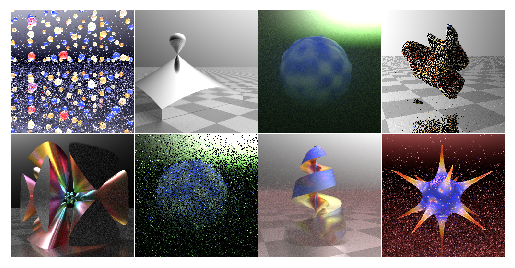

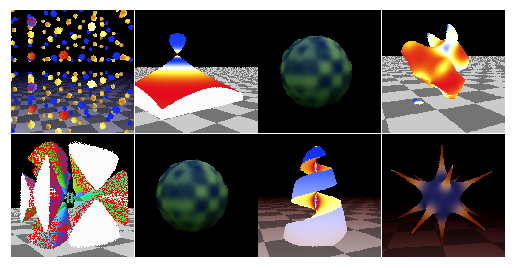

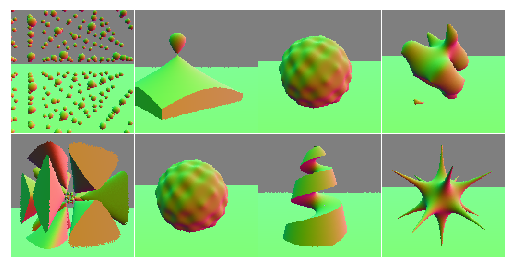

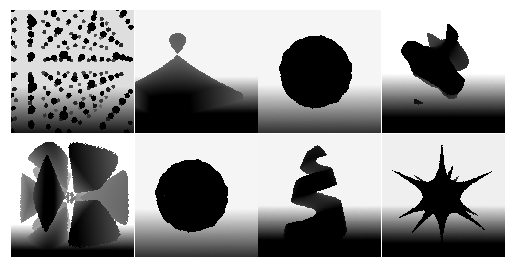

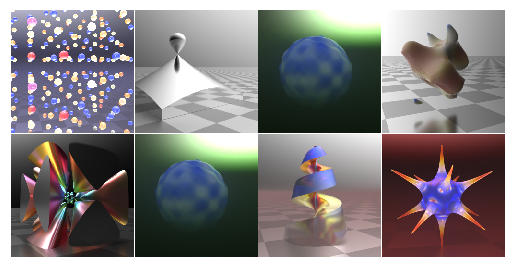

In [3]:
class RawDataset(torch.utils.data.Dataset):
    def __init__(self, n):
        import os
        self.data = [load_data_file(filename) for filename in os.listdir("data/")]
        s = 256
        self.n = n
        self.s = s
        self.coords = []
        for i in range(n):
            k = np.random.randint(0, len(self.data))
            x = np.random.randint(0, self.data[k]['w']-s+1)
            y = np.random.randint(0, self.data[k]['h']-s+1)
            self.coords.append((k, x, y))

    def __len__(self):
        return self.n

    def __getitem__(self, i):
        k, x, y = self.coords[i]
        s = self.s
        n = self.data[k]['data'].shape[0]
        total = np.zeros((3, s, s), dtype=np.float32)
        weights = np.zeros((3, s, s), dtype=np.float32)
        spp = round(0.6 * np.random.random()**4 * 2**n + 0.5)
        for _ in range(n):
            if (spp >> _) & 1 == 0:
                continue
            frame = self.data[k]['data'][_, :, x:x+s, y:y+s]
            dw = ((frame > 0.0) & (frame < 1e4)).astype(np.float32) * 2**_
            total += np.nan_to_num(frame, nan=0.0, posinf=0.0, neginf=0.0) * dw
            weights += dw
        return [
            np.fmax(total / np.fmax(weights, 1), 0.0) ** (1.0/2.2),
            self.data[k]['aux'][:, x:x+s, y:y+s],
            np.fmax(self.data[k]['ref'][:, x:x+s, y:y+s], 0.0) ** (1.0/2.2)
        ]


def plot_imgs(x):
    plt.figure()
    x = torch.clip(x, 0.0, 1.0)
    x = torch.flip(x, [2])
    plt.imshow(np.transpose(vutils.make_grid(x[:].cpu(),
        nrow=4, padding=2, pad_value=1, normalize=True), (1, 2, 0)),
                interpolation='nearest')
    plt.axis("off")
    plt.show()

for x, a, y in torch.utils.data.DataLoader(
    RawDataset(128),
    batch_size=8,
    shuffle=True
):
    break

print(x.shape)
plot_imgs(x)
plot_imgs(a[:, 0:3])
plot_imgs(a[:, 3:6]*0.5+0.5)
plot_imgs(a[:, 6:7]*0.5+0.5)
plot_imgs(y)

In [4]:
def conv3(nin, nout):
    return torch.nn.Conv2d(nin, nout, 3, padding=1, bias=True)

def conv1(nin, nout):
    return torch.nn.Conv2d(nin, nout, 1, padding=0, bias=True)

def dconv4(nin, nout):
    return torch.nn.ConvTranspose2d(nin, nout, 4, 2, 1, bias=True)

def relu(x):
    return F.relu(x, inplace=False)

def pool(x):
    return F.max_pool2d(x, 2)

def concat(a, b):
    return torch.concat((a, b), axis=1)

class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        n0 = 16
        n1 = 24
        n2 = 32
        n3 = 48
        n4 = 64
        # self.econv0 = conv3(10, n0) # 1
        self.econv0a = conv3(10, n0) # 1
        self.econv0b = conv3(n0, n0) # 1
        self.econv1 = conv3(n0, n1) # 1/2
        self.econv2 = conv3(n1, n2) # 1/4
        self.econv3 = conv3(n2, n3) # 1/8
        self.mconv1 = conv3(n3, n4) # 1/16
        self.mconv2 = conv3(n4, n4) # 1/16
        self.dconv3a = dconv4(n4, n3) # 1/16->1/8
        self.dconv3b = conv3(n3+n3, n3) # 1/8
        self.dconv2a = dconv4(n3, n2) # 1/8->1/4
        self.dconv2b = conv3(n2+n2, n2) # 1/4
        self.dconv1a = dconv4(n2, n1) # 1/4->1/2
        self.dconv1b = conv3(n1+n1, n1) # 1/2
        self.dconv0a = dconv4(n1, n0) # 1/2->1
        # self.dconv0b = conv3(n0+n0, 3) # 1
        self.dconv0b = conv3(n0+n0, n0) # 1
        self.dconv0 = conv3(n0, 3) # 1

    def forward(self, input):
        # e0 = self.econv0(input) # 1
        e0 = self.econv0b(relu(self.econv0a(input))) # 1
        e1 = self.econv1(pool(e0)) # 1/2
        e2 = self.econv2(pool(e1)) # 1/4
        e3 = self.econv3(pool(e2)) # 1/8
        m1 = self.mconv1(pool(e3)) # 1/16
        m2 = self.mconv2(relu(m1)) # 1/16
        d3 = relu(self.dconv3a(relu(m2))) # 1/8
        d3 = relu(self.dconv3b(concat(d3, e3))) # 1/8
        d2 = relu(self.dconv2a(d3)) # 1/4
        d2 = relu(self.dconv2b(concat(d2, e2))) # 1/4
        d1 = relu(self.dconv1a(d2)) # 1/2
        d1 = relu(self.dconv1b(concat(d1, e1))) # 1/2
        d0 = relu(self.dconv0a(d1)) # 1
        d0 = relu(self.dconv0b(concat(d0, e0))) # 1
        # return d0
        # return d0 + input[:, :3]
        return self.dconv0(d0)


model = Model().to(device)
print(model)

Model(
  (econv0a): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv0b): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv1): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv2): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv3): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mconv1): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mconv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dconv3a): ConvTranspose2d(64, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dconv3b): Conv2d(96, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dconv2a): ConvTranspose2d(48, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dconv2b): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dconv1a): ConvTranspose2d(32, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dconv1b): Conv2d(48,

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
256 0.10799415409564972
512 0.13601471483707428
768 0.10288918018341064
1024 0.10245133191347122
1280 0.06557941436767578
1536 0.08486031740903854
1792 0.08218275010585785
2048 0.08329826593399048


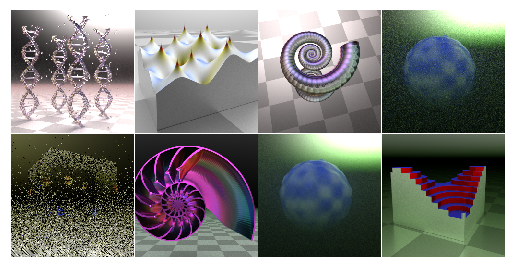

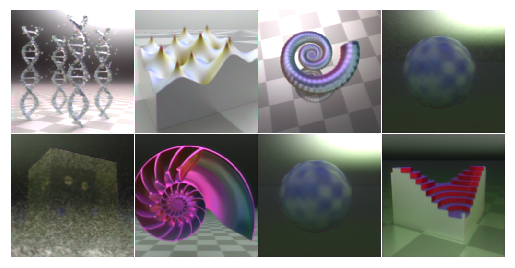

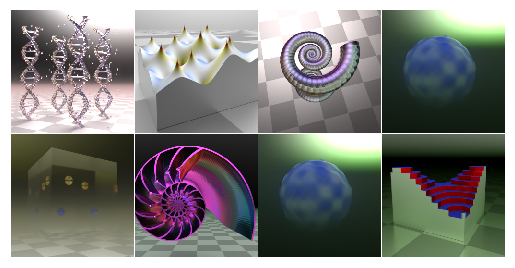

2304 0.09138627350330353
2560 0.07786182314157486
2816 0.07179424166679382
3072 0.06302506476640701
3328 0.06536742299795151
3584 0.0631103515625
3840 0.08800465613603592
4096 0.068056121468544


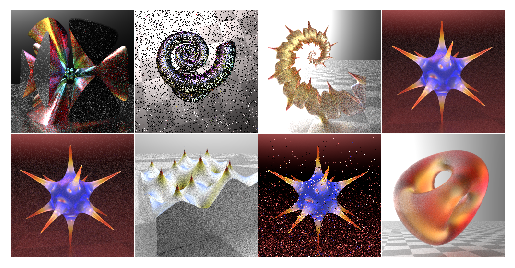

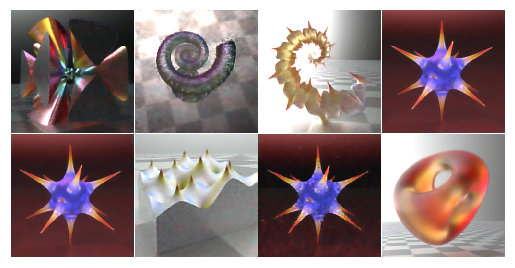

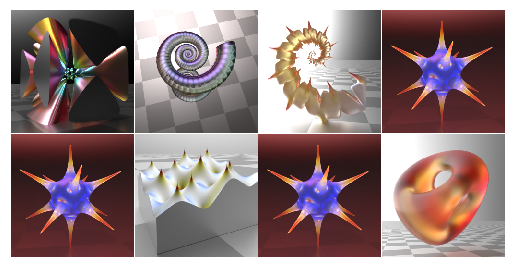

4352 0.0485377311706543
4608 0.055541615933179855
4864 0.07175491750240326
5120 0.09107764065265656
5376 0.06924879550933838
5632 0.07812504470348358
5888 0.05036195367574692
6144 0.048376038670539856


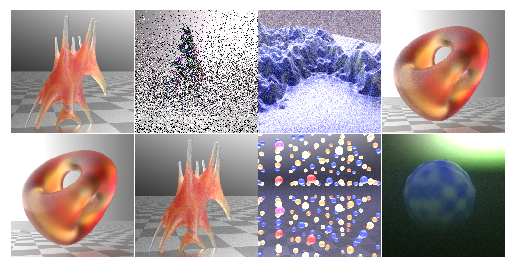

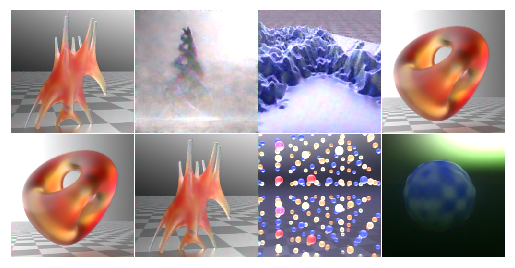

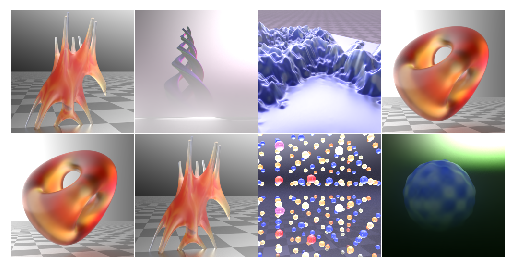

6400 0.07846509665250778
6656 0.058632537722587585
6912 0.04548832029104233
7168 0.053734369575977325
7424 0.03841652721166611
7680 0.05849966034293175
7936 0.04450232535600662
8192 0.05933438241481781


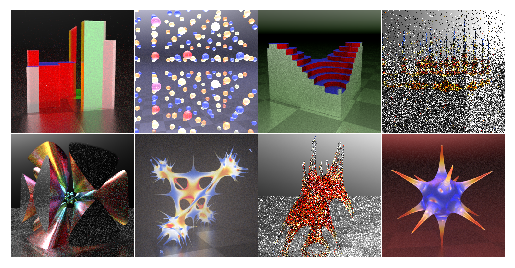

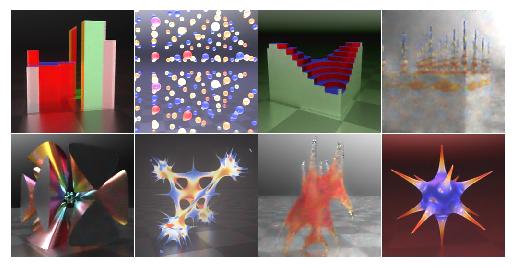

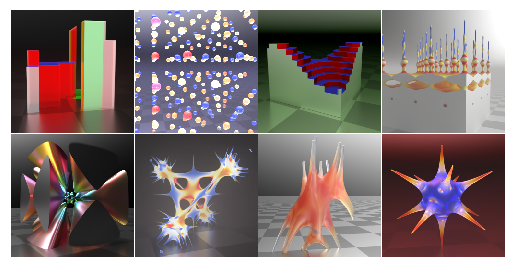

8448 0.06214234605431557
8704 0.056938543915748596
8960 0.043370235711336136
9216 0.05963684618473053
9472 0.027794137597084045
9728 0.048874665051698685
9984 0.03510662168264389
10240 0.0374242439866066


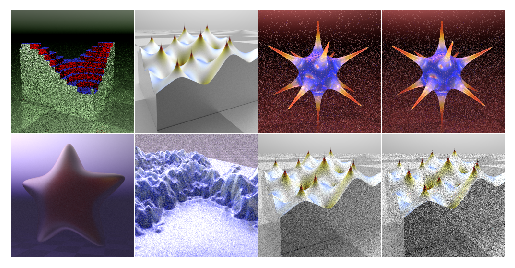

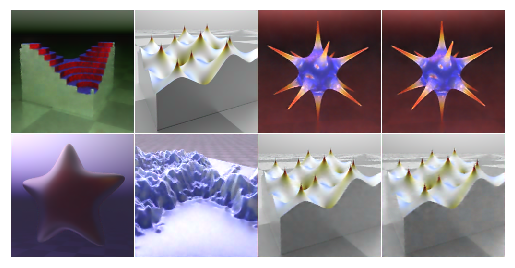

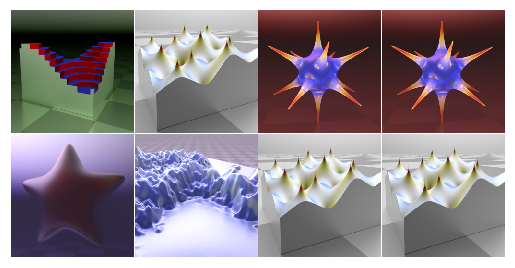

10496 0.034869201481342316
10752 0.07738321274518967
11008 0.03845004737377167
11264 0.023497307673096657
11520 0.03617459163069725
11776 0.06119394302368164
12032 0.05128607526421547
12288 0.04389426112174988


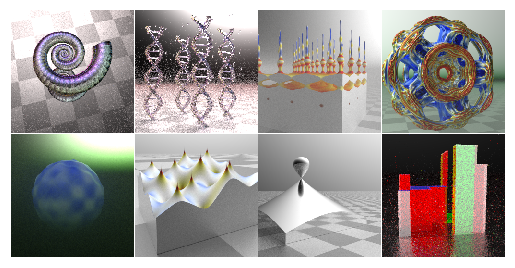

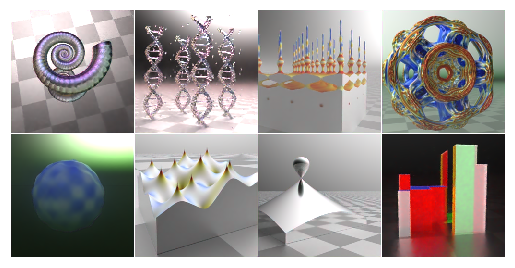

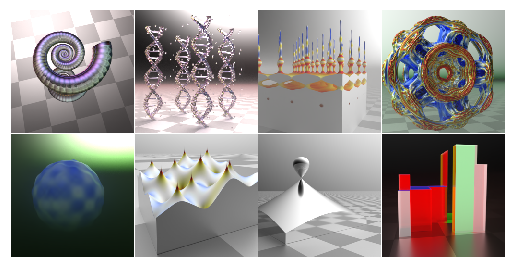

12544 0.06324955075979233
12800 0.04043680056929588
13056 0.04303920641541481
13312 0.04282918572425842
13568 0.07219210267066956
13824 0.0687733143568039
14080 0.02273475006222725
14336 0.05807214975357056


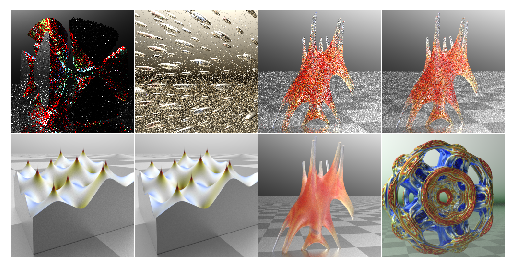

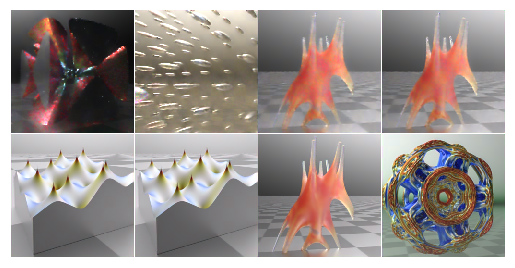

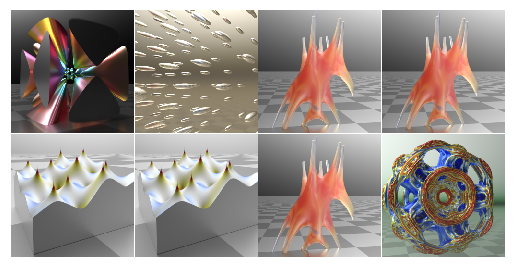

14592 0.04108467698097229
14848 0.046097323298454285
15104 0.034381184726953506
15360 0.04895477741956711
15616 0.0425342358648777
15872 0.0414351262152195
16128 0.024617156013846397
16384 0.05860867351293564


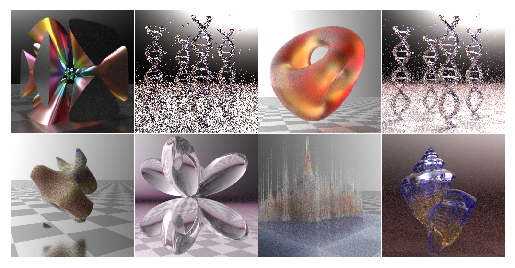

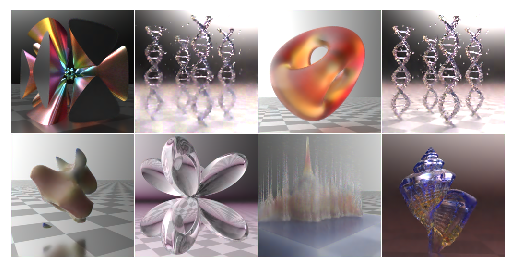

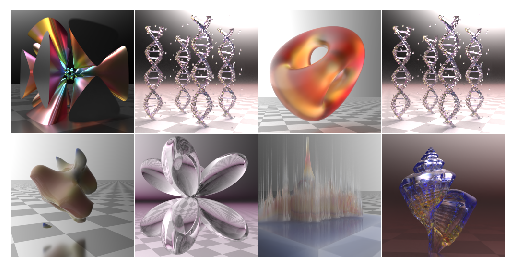

In [5]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.0001
    # lr = 0.00001
)

import torchvision.models
vgg16 = torchvision.models.vgg16(weights='VGG16_Weights.DEFAULT')
vgg16_features = vgg16.features
# vgg16_head = vgg16_features[:8].to(device)
vgg16_head = vgg16_features[:3].to(device)
print(vgg16_head)

def lossfun(output, reference, input):
    r1 = torch.mean(torch.abs(output-reference))
    r2 = torch.mean(torch.abs(vgg16_head(output)-vgg16_head(reference)))
    return r2
    return 0.5*r1 + 0.5*r2

batch_count = 0
for epoch in range(1):
    trainloader = torch.utils.data.DataLoader(
        RawDataset(2**17), batch_size=8, shuffle=True)
    for x, a, y in trainloader:
        x = x.to(device)
        a = a.to(device)
        y = y.to(device)
        x = torch.log(1+x)
        y = torch.log(1+y)
        optimizer.zero_grad()
        m_in = torch.concatenate((x, a), axis=1)
        output = model(m_in)
        loss = lossfun(output, y, x)
        loss.backward()
        optimizer.step()

        batch_count += 1
        if batch_count % 256 == 0:
            print(batch_count, loss.item())
        if batch_count % 2048 == 0:
            plot_imgs(torch.exp(x)-1)
            plot_imgs(torch.exp(output.detach())-1)
            plot_imgs(torch.exp(y)-1)


In [6]:
torch.save(model, "model1.pth")